In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import torch
import sys
from scipy.spatial.transform import Rotation as R
from argparse import ArgumentParser
import trimesh
from pytorch_lightning.loggers import TensorBoardLogger
from configargparse import ArgumentParser as ConfigArgumentParser

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

2024-01-10 02:20:25.025873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 02:20:25.928987: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-10 02:20:25.929199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-10 02:20:25.929211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
%cd ../deps/neural-head-avatars

/home/dmitry/clones/PanoHead-clostra/deps/neural-head-avatars


In [3]:
from nha.data.real import RealDataModule
from nha.models.nha_optimizer import NHAOptimizer, create_camera_objects
from nha.util.general import dict_2_device
from nha.util.render import batch_project, normalize_image_points, unnormalize_image_points
import pytorch_lightning as pl
from pytorch3d.structures import Meshes

In [4]:
optimizer_module = NHAOptimizer
data_module = RealDataModule

parser = ArgumentParser()
parser = optimizer_module.add_argparse_args(parser)
parser = data_module.add_argparse_args(parser)
parser = pl.Trainer.add_argparse_args(parser)

parser = ConfigArgumentParser(parents=[parser], add_help=False)
parser.add_argument('--config', required=True, is_config_file=True)
parser.add_argument("--checkpoint_file", type=str, required=False, default="",
                    help="checkpoint to load model from")

path = Path("/home/dmitry/clones/PanoHead-clostra/dataset/dmitry_input")
path = path.absolute()

tracking_results_path = path / 'ds' / 'tracking_results'
tracking_results_list = list(tracking_results_path.iterdir())
tracking_results_list.sort()
args = parser.parse_args([
    '--config', 'configs/optimize_avatar_mesh_guidance.ini',
    # DEBUG
    '--config', 'configs/optimize_avatar_mesh_guidance.ini', 
    '--default_root_dir', str(path / 'ds' / 'results'),
    '--tracking_results_path', str(tracking_results_list[-1] / 'tracked_flame_params.npz'),
    '--data_path', str(path / 'ds'),
    '--gpus', '1',
    '--load_threeddfa', str(path / 'dataset.json'),
    '--mesh', str(path / 'pti_out' / 'PTI_render' / 'post_mesh_level2' / 'mesh.obj'),
    '--checkpoint_file', "/home/dmitry/clones/PanoHead-clostra/dataset/dmitry_input/ds/results/lightning_logs/version_22/checkpoints/last.ckpt"

])
args_dict = vars(args)

# print(f"Start Model training with the following configuration: \n {parser.format_values()}")

# init datamodule
data = data_module(**args_dict)
data.setup()

# init optimizer
args_dict['max_frame_id'] = data.max_frame_id

if args.checkpoint_file:
    model = optimizer_module.load_from_checkpoint(args.checkpoint_file, strict=True, **args_dict)
else:
    model = optimizer_module(**args_dict)

model.cuda();

/home/dmitry/.miniconda3/envs/panohead/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: ModelCheckpoint(save_last=True, monitor=None) is a redundant configuration. You can save the last checkpoint with ModelCheckpoint(save_top_k=None, monitor=None).
  warnings.warn(*args, **kwargs)


In [5]:
train_loader = data.train_dataloader(2, shuffle=False)
sample = next(iter(train_loader))
sample = dict_2_device(sample, "cuda")

In [6]:
flame_params_offsets = model._create_flame_param_batch(sample)
# DEBUG
flame_params_offsets.pop('offsets')
offsets_verts, pred_lmks = model._forward_flame(flame_params_offsets)

K = sample["cam_intrinsic"]
RT = sample["cam_extrinsic"]

H, W = sample["rgb"].shape[-2:]

# FILL SCENE
cameras = create_camera_objects(K, RT, (H, W), model.device)
flame_meshes = Meshes(verts=offsets_verts, faces=model._flame.faces[None].expand(len(offsets_verts), -1, -1))

raster_res = model._rasterize(flame_meshes, cameras, (H, W))
mesh_raster_res = model._rasterize(model._guidance_meshes.extend(2).to(model.device), cameras, (H, W), return_initial_fragments=True)

proj_pred_lmks = batch_project(pred_lmks, K, RT, (H, W), model.device, normalize=True)
img_pred_lmks = proj_pred_lmks.clone()
img_pred_lmks[..., 0], img_pred_lmks[..., 1] = unnormalize_image_points(img_pred_lmks[..., 0], img_pred_lmks[..., 1], (H, W)) 

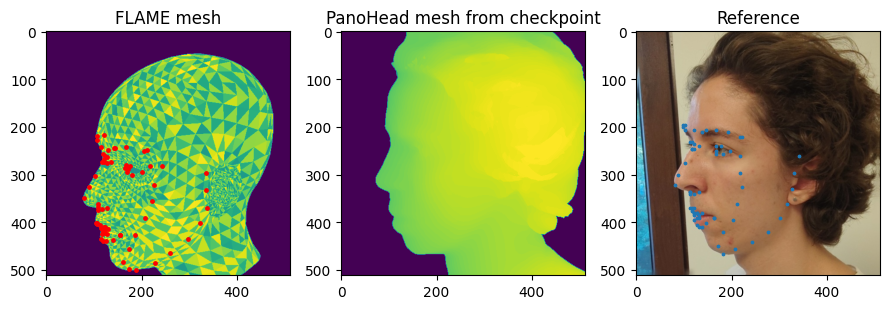

In [7]:
plt.figure(figsize=(9, 3))
idx = 1
plt.subplot(1, 3, 1)
flame_raster = raster_res[0].pix_to_face[idx].detach().cpu().numpy()
plt.imshow(flame_raster)
plt.scatter(*img_pred_lmks[idx].T.detach().cpu().numpy()[:2], c='r', s=6)
plt.title("FLAME mesh")
plt.subplot(1, 3, 2)
guidance_raster = mesh_raster_res.pix_to_face[idx].detach().cpu().numpy()[..., :1]
plt.imshow(guidance_raster)
plt.title("PanoHead mesh from checkpoint")
plt.subplot(1, 3, 3)
gt_rgb = sample['rgb'][idx].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
plt.imshow(gt_rgb)
plt.scatter(*sample["lmk2d"][idx].cpu().numpy().T[:2], s=3)
plt.title("Reference")

plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


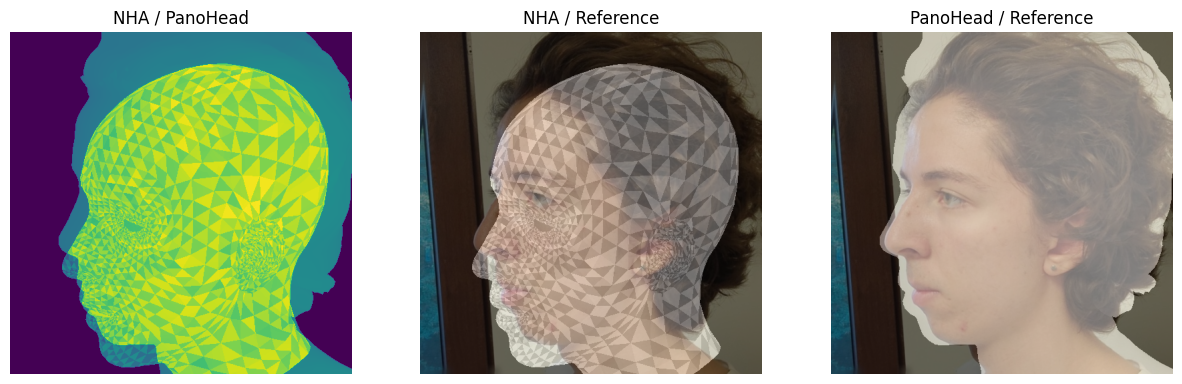

In [8]:
plt.figure(figsize=(15,5))
imgs = [flame_raster / flame_raster.max(), guidance_raster / guidance_raster.max(), gt_rgb]
titles = ["NHA", "PanoHead", "Reference"]
counter = 1
for i in range(3):
    for j in range(i + 1, 3):
        plt.subplot(1, 3, counter)
        plt.axis('off')
        plt.title(f"{titles[i]} / {titles[j]}")
        counter += 1
        plt.imshow((imgs[i] + imgs[j]) / 2)


In [112]:
lmks = sample["lmk2d"].clone()
idx=1
proj_pred_lmks = batch_project(pred_lmks, K, RT, (H, W), model.device, normalize=True)
lmks[:, :, 0], lmks[:, :, 1] = normalize_image_points(lmks[:, :, 0], lmks[:, :, 1], (H, W))

In [113]:
import cv2

In [114]:
gt_rgb_circles = gt_rgb.copy()

In [115]:
for x, y in sample["lmk2d"][idx].cpu().numpy()[:, :2]:
    cv2.circle(gt_rgb_circles, (int(x), int(y)), 3, (0, 0, 255), -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


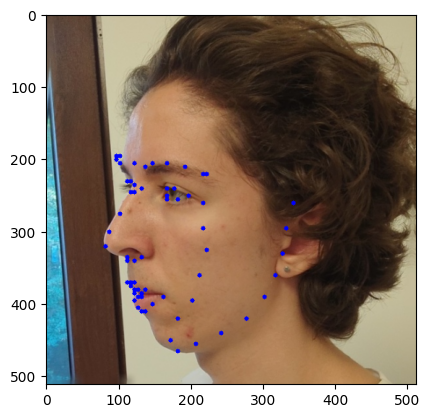

In [116]:

plt.imshow(gt_rgb_circles)

In [21]:

prediction, raster_res = model._render_semantics(
    # offsets_verts,
    offsets_verts,
    K,
    RT,
    H,
    W,
    return_rasterizer_results=True,
    rasterized_results=None,
    return_confidence=True,
)

In [ ]:
prediction.shape

torch.Size([2, 49, 512, 512])

In [23]:
semantics_pred = prediction[:, : len(model.semantic_labels)]

In [111]:
semantics_pred.shape

torch.Size([2, 24, 512, 512])

In [38]:
sample["parsing"].max()

tensor(17, device='cuda:0', dtype=torch.int32)

In [39]:
sample["rgb"].shape

torch.Size([2, 3, 512, 512])

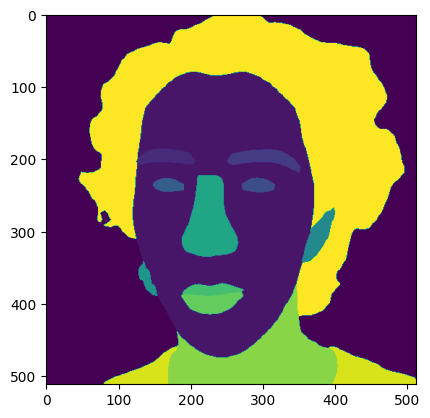

In [121]:
plt.imshow(sample["parsing"][0][0].cpu().numpy())

In [31]:
image_flat = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
image = image_flat.reshape(*reversed(fig.canvas.get_width_height()), 3)

AttributeError: 'FigureCanvasBase' object has no attribute 'tostring_rgb'

In [35]:
fig.canvas

In [36]:
fig.savefig("test.png")

In [30]:
fig = plt.Figure()
canvas = fig.canvas
ax = fig.gca()

ax.imshow(semantics_pred[0].argmax(0).detach().cpu().numpy())
ax.axis('off')

canvas.draw()  # Draw the canvas, cache the renderer

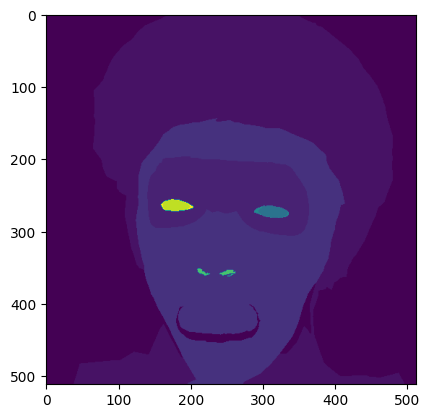

In [119]:
plt.imshow(semantics_pred[0].argmax(0).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


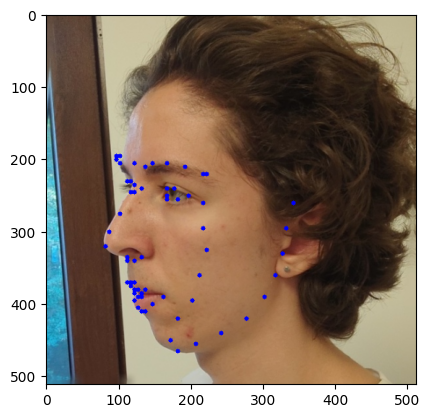

In [100]:
plt.imshow(gt_rgb_circles)

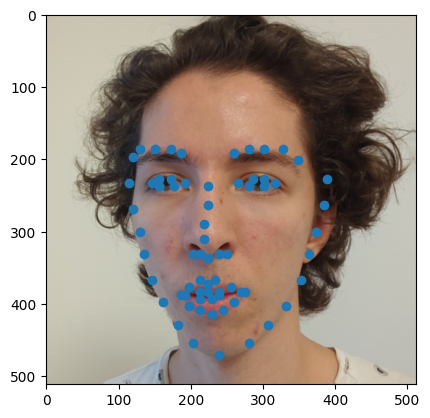

In [60]:
plt.imshow(gt_rgb)
plt.scatter(*sample["lmk2d"][idx].cpu().numpy().T[:2])

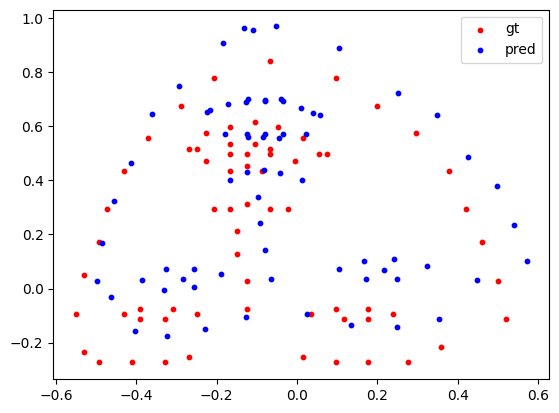

In [56]:
plt.scatter(*lmks[idx].cpu().numpy().T[:2], c='r', s=10, label='gt')
plt.scatter(*proj_pred_lmks[idx].detach().cpu().numpy().T[:2], c='b', s=10, label='pred')
plt.legend()

In [17]:
pred_lmks

tensor([[[-1.0006, -1.0000, -0.0045],
         [-1.0006, -1.0002, -0.0083],
         [-1.0006, -1.0004, -0.0110],
         [-1.0005, -1.0006,  0.0041],
         [-1.0004, -1.0008,  0.0251],
         [-1.0003, -1.0009,  0.0646],
         [-1.0002, -1.0011,  0.0765],
         [-1.0001, -1.0011,  0.1015],
         [-1.0001, -1.0011,  0.0959],
         [-1.0000, -1.0011,  0.1273],
         [-0.9998, -1.0010,  0.0922],
         [-0.9997, -1.0009,  0.0545],
         [-0.9996, -1.0008,  0.0141],
         [-0.9995, -1.0006, -0.0186],
         [-0.9994, -1.0005, -0.0343],
         [-0.9993, -1.0003, -0.0307],
         [-0.9993, -1.0001, -0.0291],
         [-1.0005, -0.9999,  0.0987],
         [-1.0004, -0.9998,  0.1296],
         [-1.0003, -0.9997,  0.1566],
         [-1.0001, -0.9998,  0.1725],
         [-1.0000, -0.9998,  0.1727],
         [-0.9998, -0.9998,  0.1703],
         [-0.9997, -0.9998,  0.1590],
         [-0.9996, -0.9998,  0.1364],
         [-0.9995, -0.9998,  0.1062],
         [-0

In [10]:
sample['lmk2d'][:, :, :2]

tensor([[[115., 232.],
         [120., 269.],
         [130., 300.],
         [135., 331.],
         [146., 367.],
         [161., 398.],
         [182., 429.],
         [203., 455.],
         [239., 471.],
         [281., 455.],
         [307., 429.],
         [332., 403.],
         [353., 367.],
         [364., 331.],
         [374., 300.],
         [384., 263.],
         [389., 227.],
         [120., 196.],
         [130., 186.],
         [151., 186.],
         [172., 186.],
         [187., 191.],
         [260., 191.],
         [281., 186.],
         [301., 186.],
         [327., 186.],
         [348., 201.],
         [224., 237.],
         [224., 263.],
         [218., 289.],
         [218., 310.],
         [203., 331.],
         [213., 331.],
         [224., 336.],
         [239., 331.],
         [250., 331.],
         [146., 232.],
         [156., 227.],
         [172., 227.],
         [192., 232.],
         [177., 237.],
         [156., 237.],
         [265., 232.],
         [2